In [11]:
from matplotlib import pyplot as plt
import numpy as np

# LOAD DATA 

In [12]:
with open('LAB1_25.TXT', 'r') as file:
    data = np.array([list(map(float, line.split())) for line in file])
time = data[:, 0] * 10**-6

# TASK 1

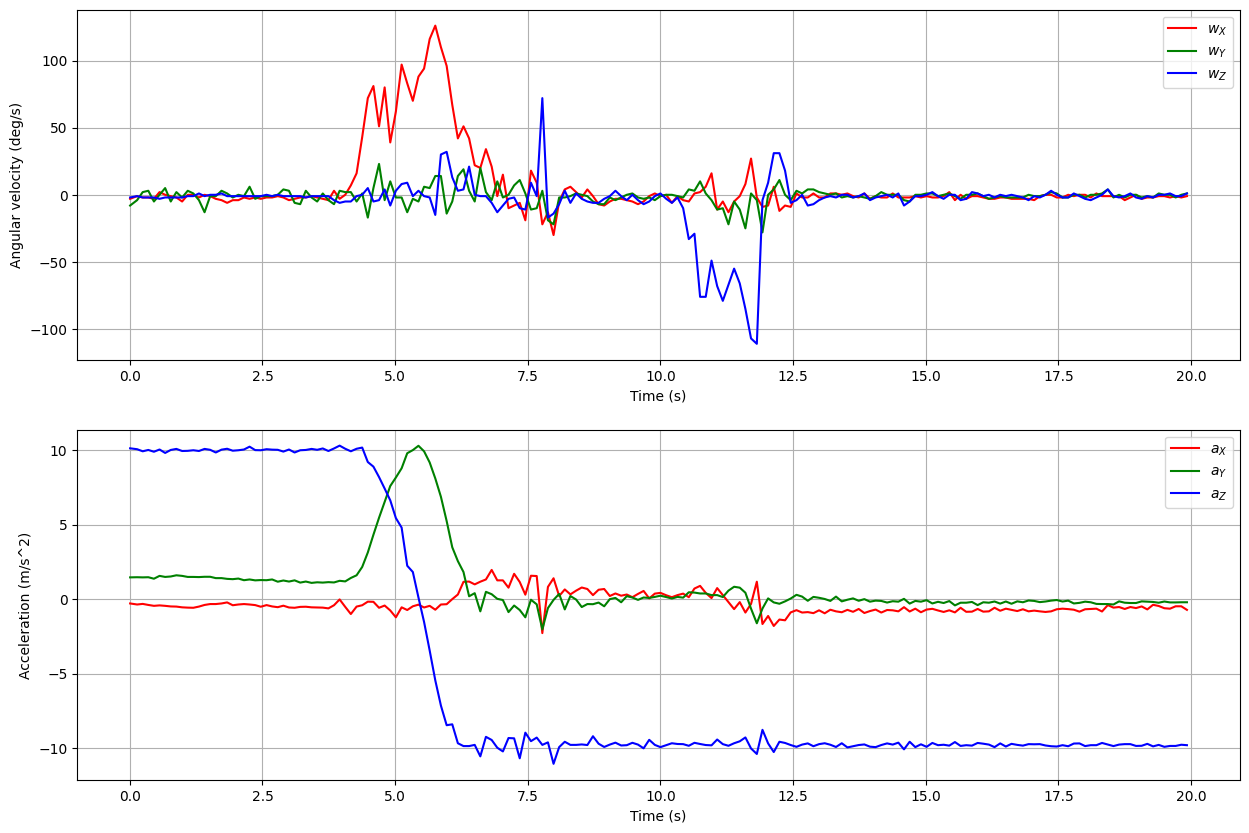

In [13]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
#accelerometer data(hundredths of meters per second squared)
acceleration = data[:, 1:4] * 0.01
#gyro-rate (degrees per second)
angular_velocity = data[:, 4:7]

plt.plot(time,angular_velocity[:, 0], color='red')
plt.plot(time,angular_velocity[:, 1], color='green')
plt.plot(time,angular_velocity[:, 2], color='blue')
#Use latex for labels
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (deg/s)')
plt.legend(['$w_X$', '$w_Y$', '$w_Z$'])


plt.grid()
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time,acceleration[:, 0], color='red')
plt.plot(time,acceleration[:, 1], color='green')
plt.plot(time,acceleration[:, 2], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['$a_X$', '$a_Y$', '$a_Z$'])
plt.show()

In [14]:
#Measure the variance of the data
static_arm_time = time > 15
var_ang_vel = np.var(angular_velocity[static_arm_time], axis=0)
mask = (angular_velocity > 3 * var_ang_vel) | (angular_velocity < -3 * var_ang_vel)
angular_velocity = np.where(mask, angular_velocity, 0)
var_acceleration = np.var(acceleration[static_arm_time], axis=0)
mask = (acceleration > 3 * var_acceleration) | (acceleration < -3 * var_acceleration)
acceleration = np.where(mask, acceleration,0)


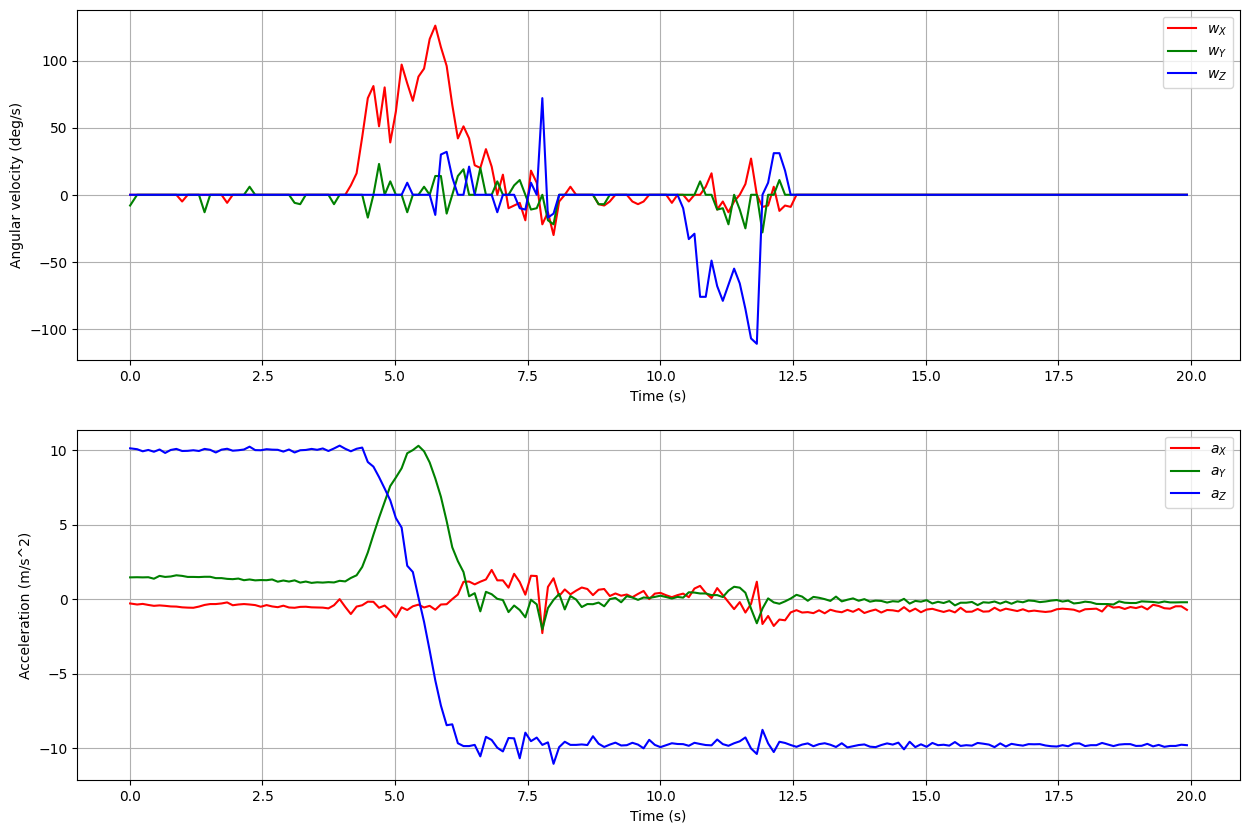

In [15]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

plt.plot(time,angular_velocity[:, 0], color='red')
plt.plot(time,angular_velocity[:, 1], color='green')
plt.plot(time,angular_velocity[:, 2], color='blue')
#Use latex for labels
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (deg/s)')
plt.legend(['$w_X$', '$w_Y$', '$w_Z$'])


plt.grid()
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(time,acceleration[:, 0], color='red')
plt.plot(time,acceleration[:, 1], color='green')
plt.plot(time,acceleration[:, 2], color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['$a_X$', '$a_Y$', '$a_Z$'])
plt.show()

# TASK 2

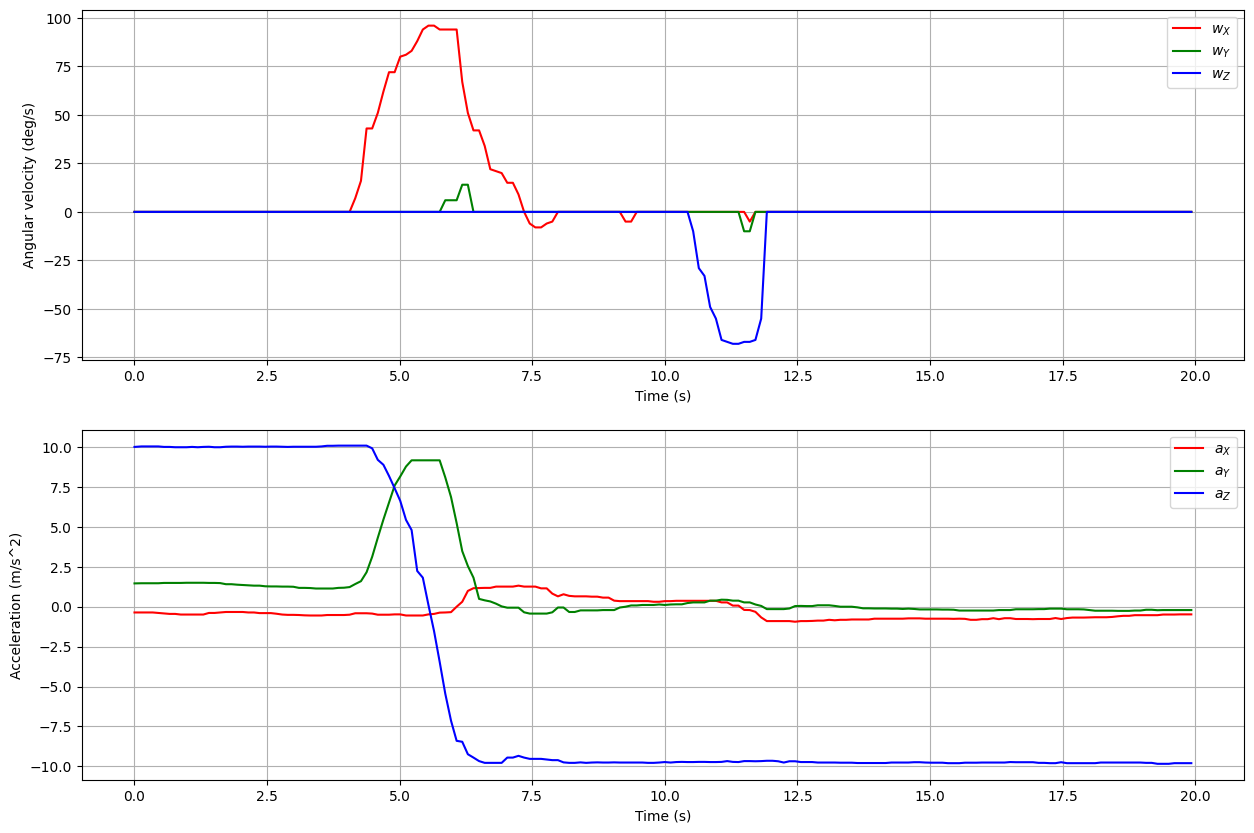

In [16]:
from scipy.ndimage import median_filter

def keep_only_moving(data, axis_moving_data):
    num_points, num_axis = data.shape
    for i in range(num_points):
        data_point = data[i]
        axis_moving = axis_moving_data[i]
        for j in range(num_axis):
            if j != axis_moving:
                data_point[j] = 0
    return data

filtered_ang_vel = median_filter(angular_velocity, size=(10,1))
filtered_acceleration = median_filter(acceleration, size=(10,1))
# axis_moving = np.argmax(filtered_ang_vel, axis=1)
# filtered_ang_vel_max = keep_only_moving(filtered_ang_vel, axis_moving)
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(time,filtered_ang_vel[:, 0], color='red')
plt.plot(time,filtered_ang_vel[:, 1], color='green')
plt.plot(time,filtered_ang_vel[:, 2], color = 'blue')
# plt.plot(time,filtered_ang_vel_max[:, 0], color='red', linestyle='--')
# plt.plot(time,filtered_ang_vel_max[:, 1], color='green', linestyle='--')
# plt.plot(time,filtered_ang_vel_max[:, 2], color='blue', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angular velocity (deg/s)')
plt.legend(['$w_X$', '$w_Y$', '$w_Z$'])
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(time,filtered_acceleration[:, 0], color='red')
plt.plot(time,filtered_acceleration[:, 1], color='green')
plt.plot(time,filtered_acceleration[:, 2], color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['$a_X$', '$a_Y$', '$a_Z$'])
plt.grid()
plt.show()


In [17]:
Initial_roll = 0
for i in range(39, 70):
    dt = time[i] - time[i-1]
    Initial_roll += filtered_ang_vel[i, 0] * dt
    # print(f'{Initial_roll:=}, {i=:}, {time[i]=:}, {filtered_ang_vel[i, 0]=:}, {dt=:}')
print(Initial_roll)

180.14211999999998


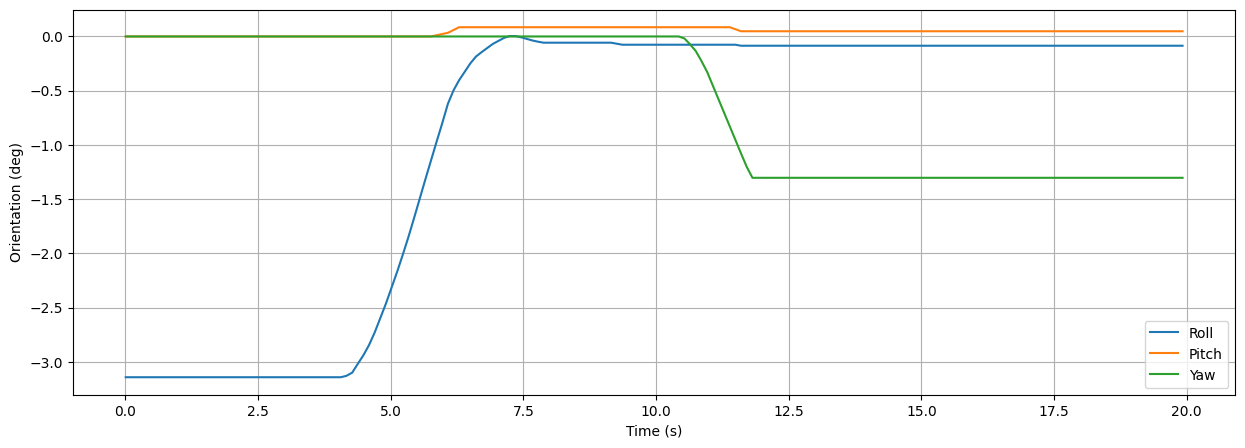

In [18]:
def normalize_angle(angle):
    for i in range(len(angle[-1])):
        angle[-1][i] = (angle[-1][i] + 180) % 360 - 180
    return angle

orientation = [[180,0,0]] #Initial orientation extracted by looking at the acceleration data (measuring the gravity acceleration at the beginning)
normalize_angle(orientation)
for i,ang_vel in enumerate(filtered_ang_vel[1:]):
    dt = time[i] - time[i-1]
    orientation.append(orientation[-1] + ang_vel * dt)
    normalize_angle(orientation)

orientation = np.radians(orientation)

plt.figure(figsize=(15, 5))
plt.plot(time, orientation)
plt.xlabel('Time (s)')
plt.ylabel('Orientation (deg)')
plt.legend(['Roll', 'Pitch', 'Yaw'])
plt.grid()

In [19]:
def rotation_matrix(roll, pitch, yaw):
    """
    """
    c_yaw, s_yaw = np.cos(yaw), np.sin(yaw)  # cos(α), sin(α)
    c_pitch, s_pitch = np.cos(pitch), np.sin(pitch)  # cos(β), sin(β)
    c_roll, s_roll = np.cos(roll), np.sin(roll)  # cos(γ), sin(γ)
    
    # Rotation matrix computation
    R = np.array([
        [c_yaw * c_pitch, c_yaw * s_pitch * s_roll - s_yaw * c_roll, c_yaw * s_pitch * c_roll + s_yaw * s_roll],
        [s_yaw * c_pitch, s_yaw * s_pitch * s_roll + c_yaw * c_roll, s_yaw * s_pitch * c_roll - c_yaw * s_roll],
        [-s_pitch, c_pitch * s_roll, c_pitch * c_roll]
    ])
    
    return R

# Trajetória

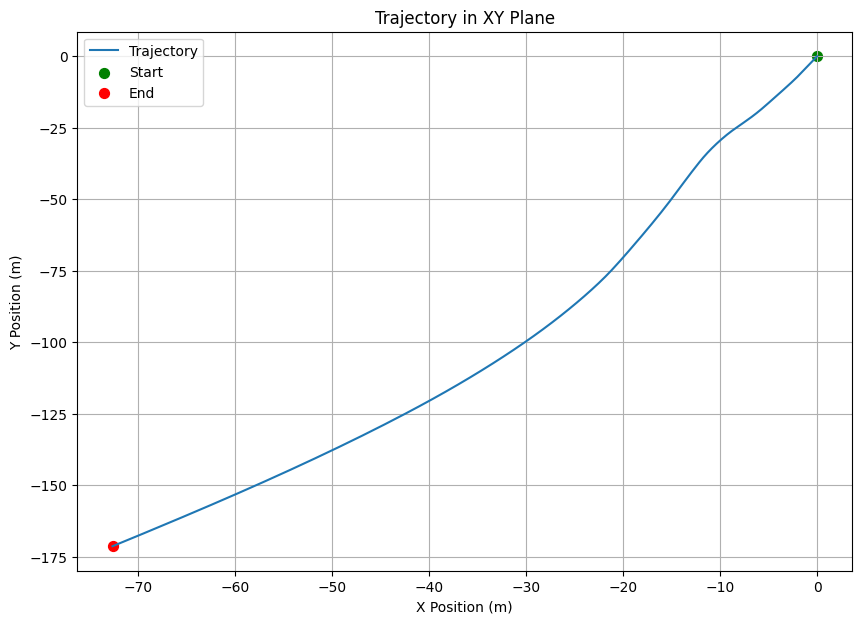

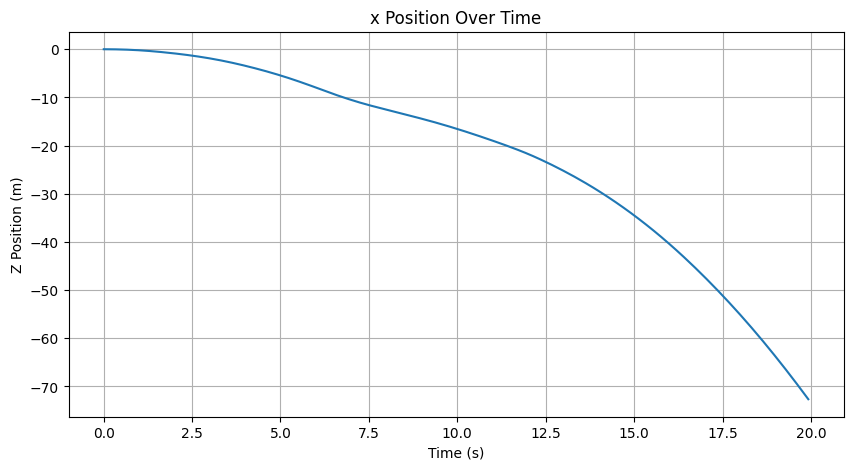

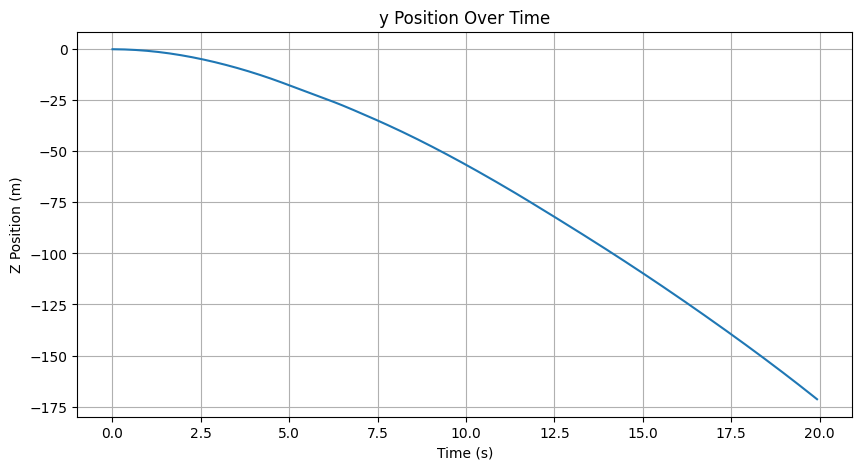

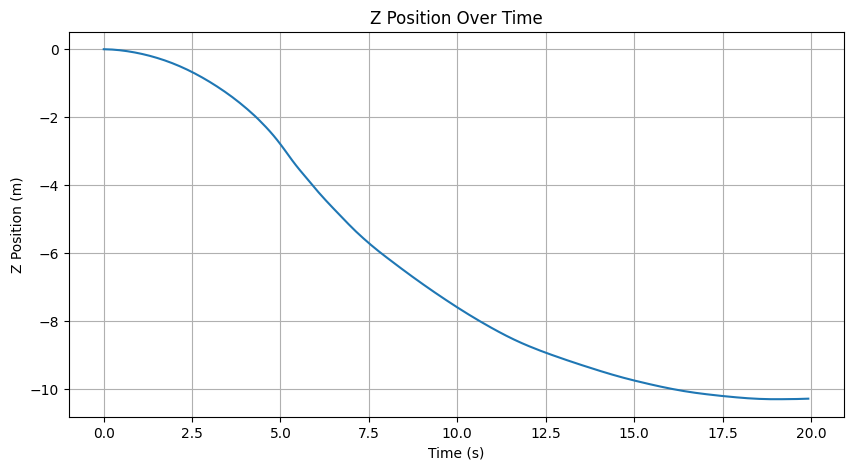

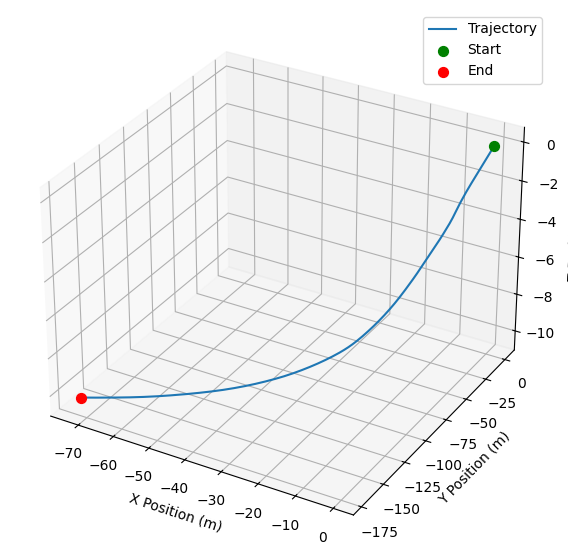

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
# time = np.arange(0, 4, 1)
# filtered_acceleration = np.array([[0.0, 0.0, 9.81], [1.0,0.0,-9.81], [0.5,0.0,-9.81], [0.0, -9.81,0.0]])  # Assuming constant gravity
# filtered_ang_vel = np.array([[0.0, 0.0, 0.0], [180, 0.0, 0.0], [0.0, 0.0, 180], [90.0, 0.0, 0.0]])
# Assuming time, acceleration, and angular_velocity are already defined
num_samples = len(time)
dt = np.diff(time, prepend=time[0])

# Convert gyroscope data from degrees per second to radians per second
gyro_rad = np.deg2rad(filtered_ang_vel)

# Initialize orientation as identity quaternion
orientations = np.zeros((num_samples, 4))
orientations[0] = R.from_euler('xyz', [np.pi, 0, 0], degrees=False).as_quat()

for i in range(1, num_samples):
    # Angular velocity in this time step
    omega = gyro_rad[i] * dt[i]  # Angular displacement
    omega_mag = np.linalg.norm(omega)
    
    if omega_mag > 0:
        # Compute rotation increment
        axis = omega / omega_mag
        delta_rot = R.from_rotvec(axis * omega_mag)
    else:
        delta_rot = R.identity()
    
    # Update orientation
    prev_orientation = R.from_quat(orientations[i - 1])
    current_orientation = prev_orientation * delta_rot
    orientations[i] = current_orientation.as_quat()

# Initialize arrays for acceleration, velocity, and position in world frame
acceleration_world = np.zeros((num_samples, 3))
velocity_world = np.zeros((num_samples, 3))
position_world = np.zeros((num_samples, 3))

gravity_world = np.array([0, 0, -9.81])  # Gravity vector in world frame

for i in range(num_samples):
    # Rotate accelerometer data to world frame
    current_orientation = R.from_quat(orientations[i])
    acc_world = current_orientation.apply(filtered_acceleration[i])
    
    # Subtract gravity to get net acceleration
    net_acc = acc_world - gravity_world
    
    if i > 0:
        # Integrate acceleration to get velocity
        velocity_world[i] = velocity_world[i - 1] + net_acc * dt[i]
        # Integrate velocity to get position
        position_world[i] = position_world[i - 1] + velocity_world[i] * dt[i]

# Plot the trajectory
plt.figure(figsize=(10, 7))
plt.plot(position_world[:, 0], position_world[:, 1], label="Trajectory")
plt.scatter(position_world[0, 0], position_world[0, 1], color="green", label="Start", s=50)
plt.scatter(position_world[-1, 0], position_world[-1, 1], color="red", label="End", s=50)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.title('Trajectory in XY Plane')
plt.grid()
plt.show()

# Plot Z position over time to verify constant height
plt.figure(figsize=(10, 5))
plt.plot(time, position_world[:, 0], label="Z Position")
plt.xlabel('Time (s)')
plt.ylabel('x Position (m)')
plt.title('x Position Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time, position_world[:, 1], label="Z Position")
plt.xlabel('Time (s)')
plt.ylabel('y Position (m)')
plt.title('y Position Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time, position_world[:, 2], label="Z Position")
plt.xlabel('Time (s)')
plt.ylabel('Z Position (m)')
plt.title('Z Position Over Time')
plt.grid()
plt.show()


# Plot the trajectory
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(position_world[:, 0], position_world[:, 1], position_world[:, 2], label="Trajectory")
ax.scatter(position_world[0, 0], position_world[0, 1], position_world[0, 2], color="green", label="Start", s=50)
ax.scatter(position_world[-1, 0], position_world[-1, 1], position_world[-1, 2], color="red", label="End", s=50)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.legend()
plt.show()